<a href="https://colab.research.google.com/github/mlc-ai/notebooks/blob/main/7_GPU_and_Specialized_Hardware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ep7: GPU and Hardware Acceleration, Part 1

## Install packages 

For this course, we will use some ongoing development in tvm, which is an open-source machine learning compilation framework. We provide the following command to install a packaged version for mlc course. This particular notebook depends on a CUDA11 environment.

In [1]:
!python3 -m  pip install mlc-ai-nightly-cu110 -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     |████████████████████████████████| 237.1 MB 11 kB/s 


In [2]:
!nvidia-smi

Sat Aug  6 12:22:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Prelude

In the past chapter, we discussed  MLC flows in CPU environments. This chapter will discuss how to bring some of the optimizations onto GPU. We are going to use CUDA terminology. However, the same set of concepts applies to other kinds of GPUs as well.


## Preparations

To begin with, let us import the necessary dependencies.


In [3]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
from tvm import relax
import numpy as np

# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations 

## GPU Architecture

Let us begin by reviewing what a GPU architecture looks like. A typical GPU contains a collection of stream multi-processors, and each multi-processor has many cores. A GPU device is massively parallel and allows us to execute many tasks concurrently.

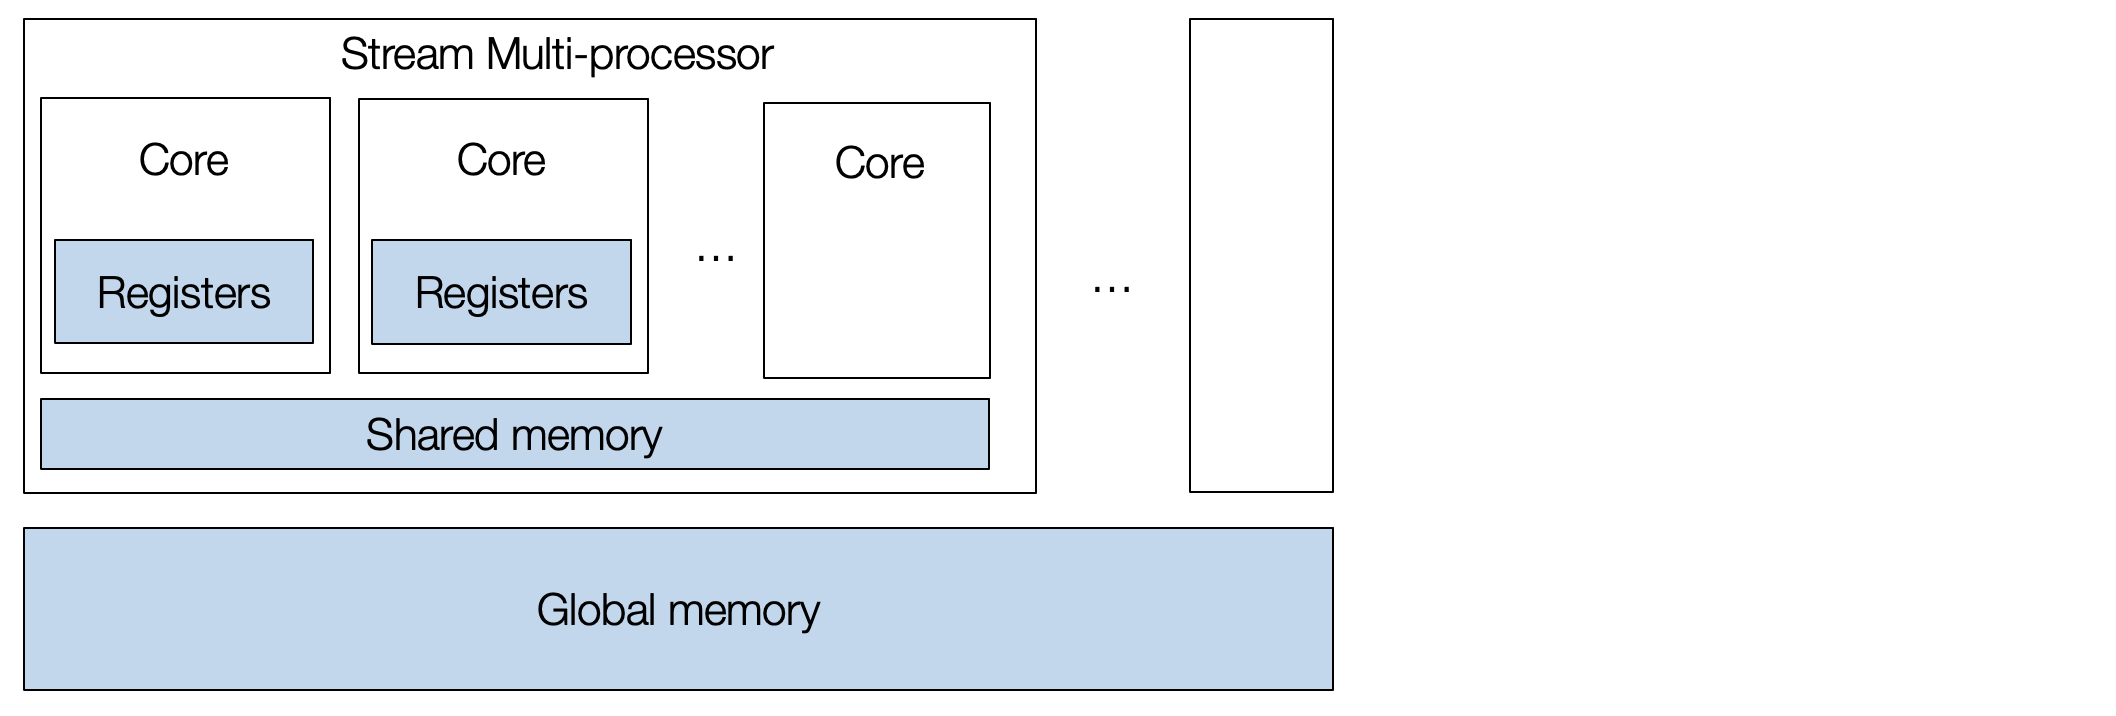

To program a GPU, we need to create a set of thread blocks, with each thread mapping to the cores and the thread block map to the stream multiprocessors.

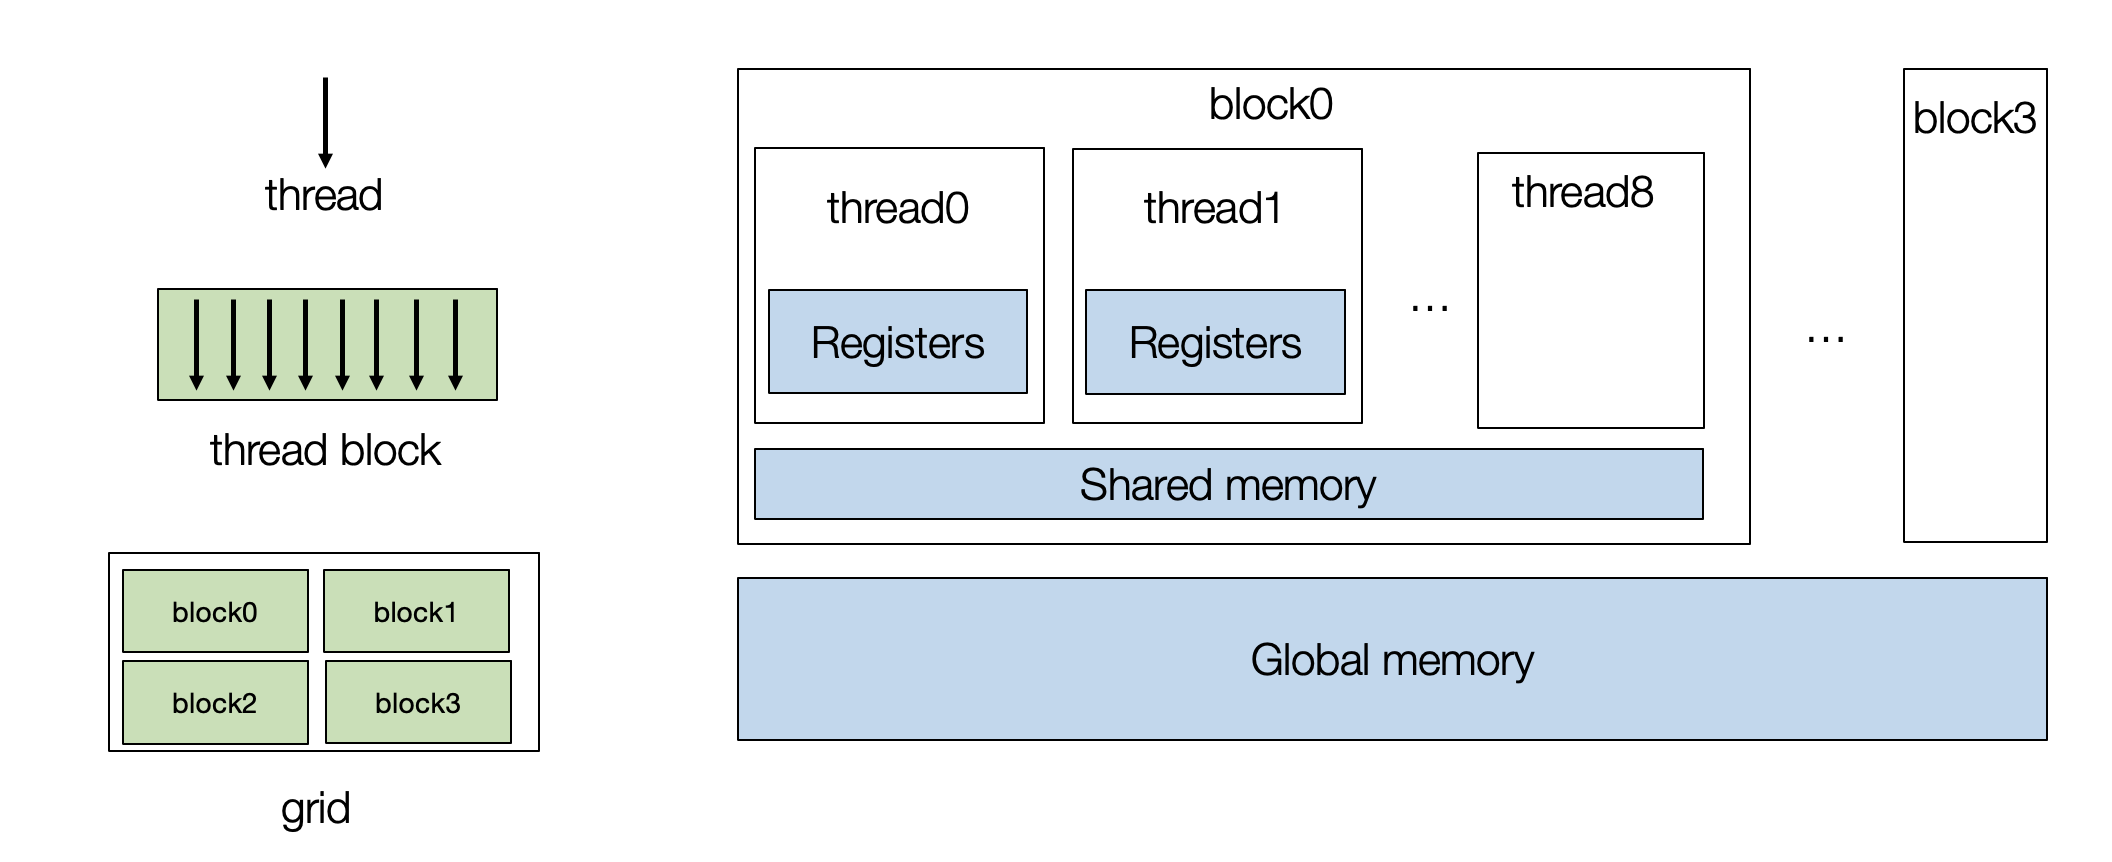

Let us start GPU programming using a vector add example. The following TensorIR program takes two vectors, A and B, performs element-wise add, and stores the result in C.

In [4]:
@tvm.script.ir_module
class MyModuleVecAdd:
    @T.prim_func
    def main(A: T.Buffer[(1024,), "float32"], 
             B: T.Buffer[(1024,), "float32"], 
             C: T.Buffer[(1024,), "float32"]) -> None:
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i in T.grid(1024):
            with T.block("C"):
                vi = T.axis.remap("S", [i])
                C[vi] = A[vi] + B[vi]

We first split loop `i` into two loops.

In [5]:
sch = tvm.tir.Schedule(MyModuleVecAdd)
block_C = sch.get_block("C")
i, = sch.get_loops(block=block_C)
i0, i1 = sch.split(i, [None, 128])
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[1024, "float32"], B: T.Buffer[1024, "float32"], C: T.Buffer[1024, "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        for i_0, i_1 in T.grid(8, 128):
            with T.block("C"):
                vi = T.axis.spatial(1024, i_0 * 128 + i_1)
                T.reads(A[vi], B[vi])
                T.writes(C[vi])
                C[vi] = A[vi] + B[vi]
    



### GPU Thread Blocks

Then we bind the iterators to the GPU thread blocks. Each thread is parameterized by two indices -- `threadIdx.x` and `blockIdx.x`. In practice, we can have multiple dimensional thread indices, but we keep them simple as one dimension.

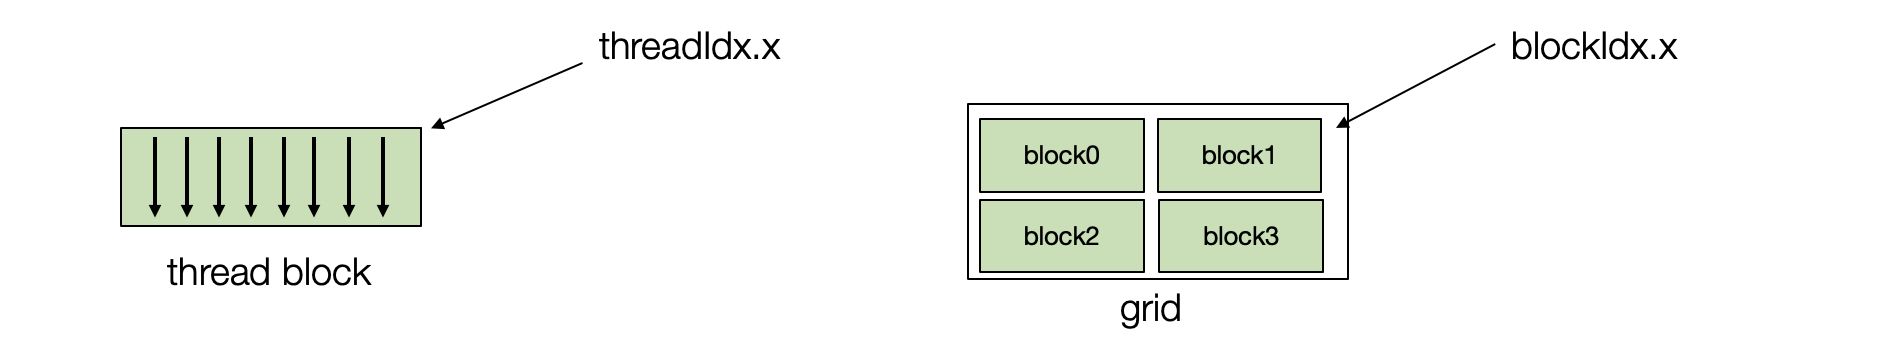

In [6]:
sch.bind(i0, "blockIdx.x")
sch.bind(i1, "threadIdx.x")
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[1024, "float32"], B: T.Buffer[1024, "float32"], C: T.Buffer[1024, "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        for i_0 in T.thread_binding(8, thread="blockIdx.x"):
            for i_1 in T.thread_binding(128, thread="threadIdx.x"):
                with T.block("C"):
                    vi = T.axis.spatial(1024, i_0 * 128 + i_1)
                    T.reads(A[vi], B[vi])
                    T.writes(C[vi])
                    C[vi] = A[vi] + B[vi]
    



### Build and Run the TensorIR Function on GPU

We can build and test out the resulting function on the GPU.

In [7]:
rt_mod = tvm.build(sch.mod, target="cuda")

A_np = np.random.uniform(size=(1024,)).astype("float32")
B_np = np.random.uniform(size=(1024,)).astype("float32")
A_nd = tvm.nd.array(A_np, tvm.cuda(0))
B_nd = tvm.nd.array(B_np, tvm.cuda(0))
C_nd = tvm.nd.array(np.zeros((1024,), dtype="float32"), tvm.cuda(0))

rt_mod["main"](A_nd, B_nd, C_nd)
print(A_nd)
print(B_nd)
print(C_nd)

[0.22986071 0.6248589  0.42811215 ... 0.711083   0.15574457 0.5856954 ]
[0.11039166 0.5747334  0.04899056 ... 0.32799527 0.8146758  0.92701113]
[0.34025237 1.1995924  0.4771027  ... 1.0390782  0.97042036 1.5127065 ]


In [8]:
np.testing.assert_allclose(C_nd.numpy(), A_np + B_np)

## Window Sum Example

Now, let us move forward to another example -- window sum. This program can be viewed as a basic version of "convolution" with a predefined weight `[1,1,1]`. We are taking sliding over the input and add three neighboring values together.

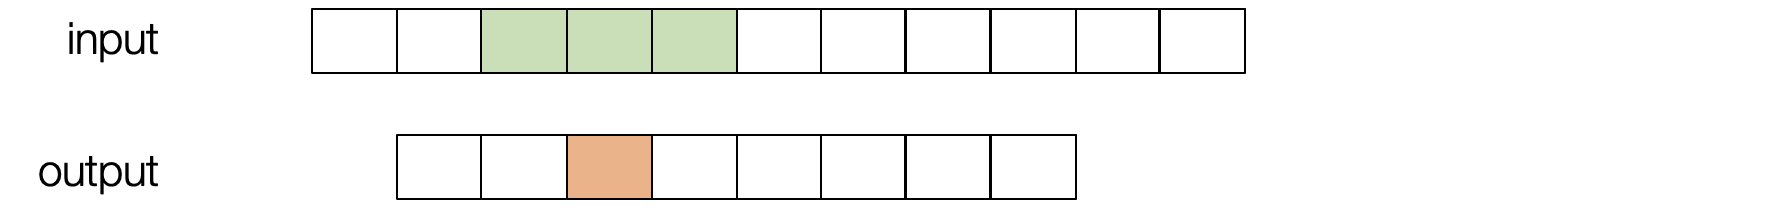

In [9]:
@tvm.script.ir_module
class MyModuleWindowSum:
    @T.prim_func
    def main(A: T.Buffer[(1027,), "float32"], 
             B: T.Buffer[(1024,), "float32"]) -> None:
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i in T.grid(1024):
            with T.block("C"):
                vi = T.axis.remap("S", [i])
                B[vi] = A[vi] + A[vi + 1] + A[vi + 2]

First, we can bind the loop to GPU threads.

In [10]:
sch = tvm.tir.Schedule(MyModuleWindowSum)
nthread = 128
block_C = sch.get_block("C")
i,  = sch.get_loops(block=block_C)
i0, i1 = sch.split(i, [None, nthread])
sch.bind(i0, "blockIdx.x")
sch.bind(i1, "threadIdx.x")
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[1027, "float32"], B: T.Buffer[1024, "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        for i_0 in T.thread_binding(8, thread="blockIdx.x"):
            for i_1 in T.thread_binding(128, thread="threadIdx.x"):
                with T.block("C"):
                    vi = T.axis.spatial(1024, i_0 * 128 + i_1)
                    T.reads(A[vi : vi + 3])
                    T.writes(B[vi])
                    B[vi] = A[vi] + A[vi + 1] + A[vi + 2]
    



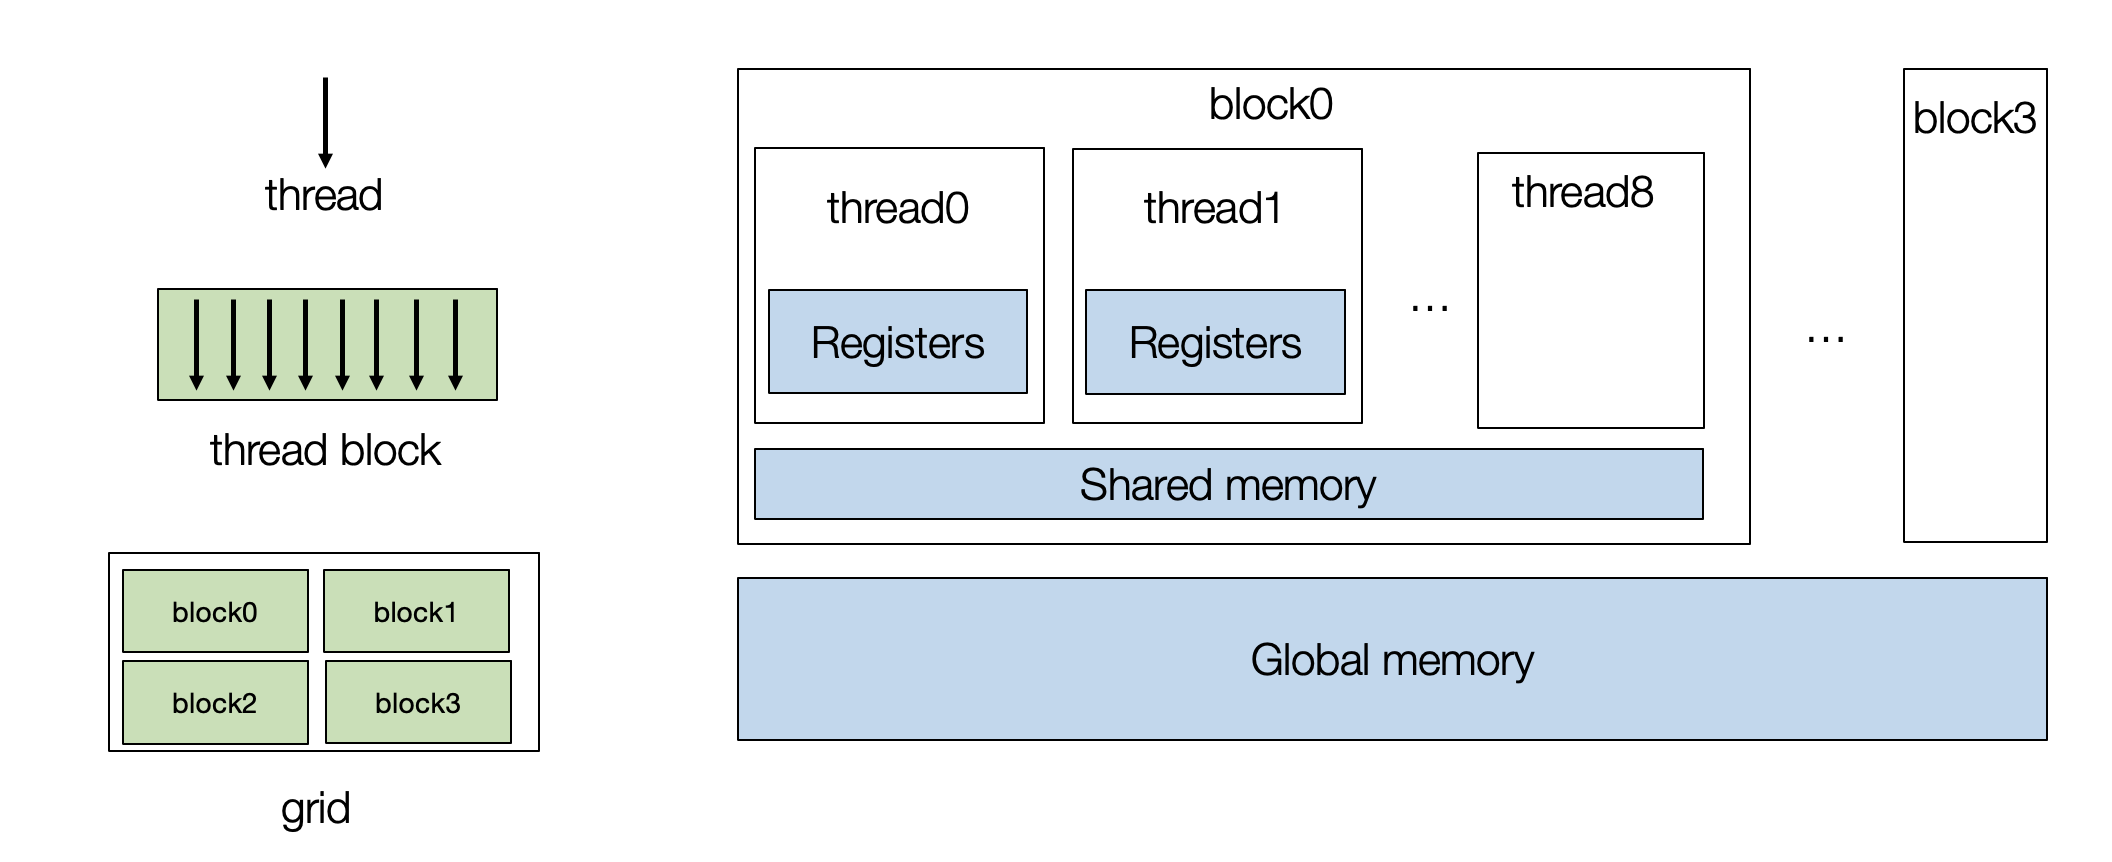

Importantly, in this case, there are reuse opportunities. Remember that each GPU thread block contains shared memory that all threads can access within the block. We use `cache_read` to add an intermediate stage that caches segments (in green below) onto the shared memory. After the caching is finished, the threads can then read from the shared memory.

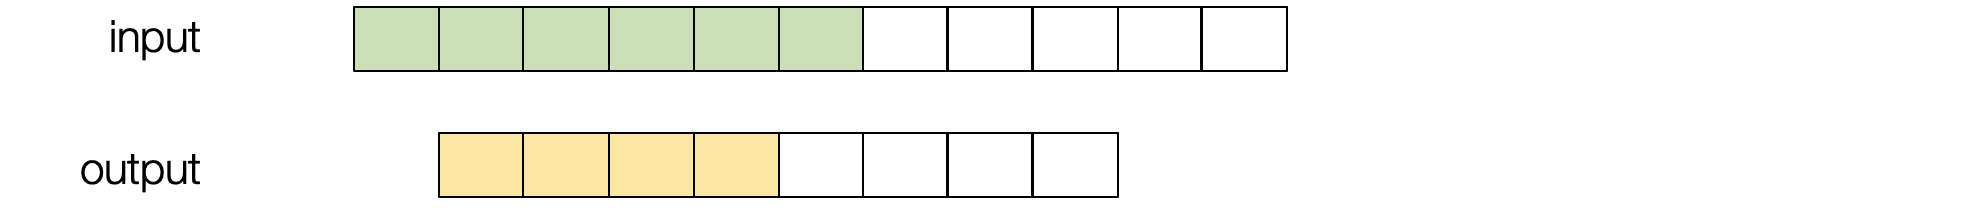

In [11]:
A_shared = sch.cache_read(block_C, read_buffer_index=0, storage_scope="shared")
sch.compute_at(A_shared, i1)
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[1027, "float32"], B: T.Buffer[1024, "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        A_shared = T.alloc_buffer([1027], dtype="float32", scope="shared")
        for i_0 in T.thread_binding(8, thread="blockIdx.x"):
            for i_1 in T.thread_binding(128, thread="threadIdx.x"):
                for ax0 in T.serial(130):
                    with T.block("A_shared"):
                        v0 = T.axis.spatial(1027, i_0 * 128 + ax0)
                        T.reads(A[v0])
                        T.writes(A_shared[v0])
                        A_shared[v0] = A[v0]
                with T.block("C"):
                    vi = T.axis.spatial(1024, i_0 * 128 + i_1)
                    T.reads(A_shared[vi : vi + 3])
                    T.writes(B[vi])
                    B[vi] = A_shared[vi] + A_sh

Because the memory is shared across threads, we need to resplit the loop and bind the inner iterator of the fetching process onto the thread indices. This technique is called **cooperative fetching**, where multiple threads work together to bring the data onto the shared memory. The following reading process can be different. 

In [12]:
ax = sch.get_loops(A_shared)[-1]
ax0, ax1 = sch.split(ax, [None, nthread])
sch.bind(ax1, "threadIdx.x")
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[1027, "float32"], B: T.Buffer[1024, "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        A_shared = T.alloc_buffer([1027], dtype="float32", scope="shared")
        for i_0 in T.thread_binding(8, thread="blockIdx.x"):
            for i_1 in T.thread_binding(128, thread="threadIdx.x"):
                for ax0_0 in T.serial(2):
                    for ax0_1 in T.thread_binding(128, thread="threadIdx.x"):
                        with T.block("A_shared"):
                            v0 = T.axis.spatial(1027, i_0 * 128 + (ax0_0 * 128 + ax0_1))
                            T.where(ax0_0 * 128 + ax0_1 < 130)
                            T.reads(A[v0])
                            T.writes(A_shared[v0])
                            A_shared[v0] = A[v0]
                with T.block("C"):
                  

We can inspect the corresponding low-level code (in CUDA). The generated code contains two parts: 
- A host part that calls into the GPU driver
- A cuda kernel that runs the corresponding computation.

We can print out the cuda kernel using the following code. We still need both the host and kernel code to run the program, so it is only a quick way to inspect what the final code generation result.

Notably, the build process automatically compacts the shared memory stage to use a minimum region used within the thread block.

In [13]:
rt_mod = tvm.build(sch.mod, target="cuda")
print(rt_mod.imported_modules[0].get_source())


#ifdef _WIN32
  using uint = unsigned int;
  using uchar = unsigned char;
  using ushort = unsigned short;
  using int64_t = long long;
  using uint64_t = unsigned long long;
#else
  #define uint unsigned int
  #define uchar unsigned char
  #define ushort unsigned short
  #define int64_t long long
  #define uint64_t unsigned long long
#endif
extern "C" __global__ void __launch_bounds__(128) main_kernel0(float* __restrict__ A, float* __restrict__ B) {
  __shared__ float A_shared[130];
  for (int ax0_0 = 0; ax0_0 < 2; ++ax0_0) {
    if (((ax0_0 * 64) + (((int)threadIdx.x) >> 1)) < 65) {
      A_shared[((ax0_0 * 128) + ((int)threadIdx.x))] = A[(((((int)blockIdx.x) * 128) + (ax0_0 * 128)) + ((int)threadIdx.x))];
    }
  }
  __syncthreads();
  B[((((int)blockIdx.x) * 128) + ((int)threadIdx.x))] = ((A_shared[((int)threadIdx.x)] + A_shared[(((int)threadIdx.x) + 1)]) + A_shared[(((int)threadIdx.x) + 2)]);
}




### Build Code for Other GPU Platforms

A MLC process usually support targeting multiple kinds of hardware platforms, we can generate opencl code(which is another kind of GPU programming model) by changing the target parameter.

In [14]:
rt_mod = tvm.build(sch.mod, target="metal")
print(rt_mod.imported_modules[0].get_source())

// Function: main_kernel0
#include <metal_stdlib>
using namespace metal;

union __TVMArgUnion {
 int v_int[2];
};

kernel void main_kernel0(  device float* A [[ buffer(0) ]],
  device float* B [[ buffer(1) ]],
  uint blockIdx [[threadgroup_position_in_grid]],
  uint threadIdx [[thread_position_in_threadgroup]]
) {
  threadgroup float A_shared[130];
  for (int ax0_0 = 0; ax0_0 < 2; ++ax0_0) {
    if (((ax0_0 * 64) + (((int)threadIdx) >> 1)) < 65) {
      A_shared[((ax0_0 * 128) + ((int)threadIdx))] = A[(((((int)blockIdx) * 128) + (ax0_0 * 128)) + ((int)threadIdx))];
    }
  }
  threadgroup_barrier(mem_flags::mem_threadgroup);
  B[((((int)blockIdx) * 128) + ((int)threadIdx))] = ((A_shared[((int)threadIdx)] + A_shared[(((int)threadIdx) + 1)]) + A_shared[(((int)threadIdx) + 2)]);
}




## Matrix Multiplication

Let us now get to something slightly more complicated and try out optimizing matrix multiplication on GPU. We will go over two common techniques for GPU performance optimization.





In [15]:
@tvm.script.ir_module
class MyModuleMatmul:
    @T.prim_func
    def main(A: T.Buffer[(1024, 1024), "float32"], 
             B: T.Buffer[(1024, 1024), "float32"], 
             C: T.Buffer[(1024, 1024), "float32"]) -> None:
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i, j, k in T.grid(1024, 1024, 1024):
            with T.block("C"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    C[vi, vj] = 0.0
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vk, vj]

### Local Blocking



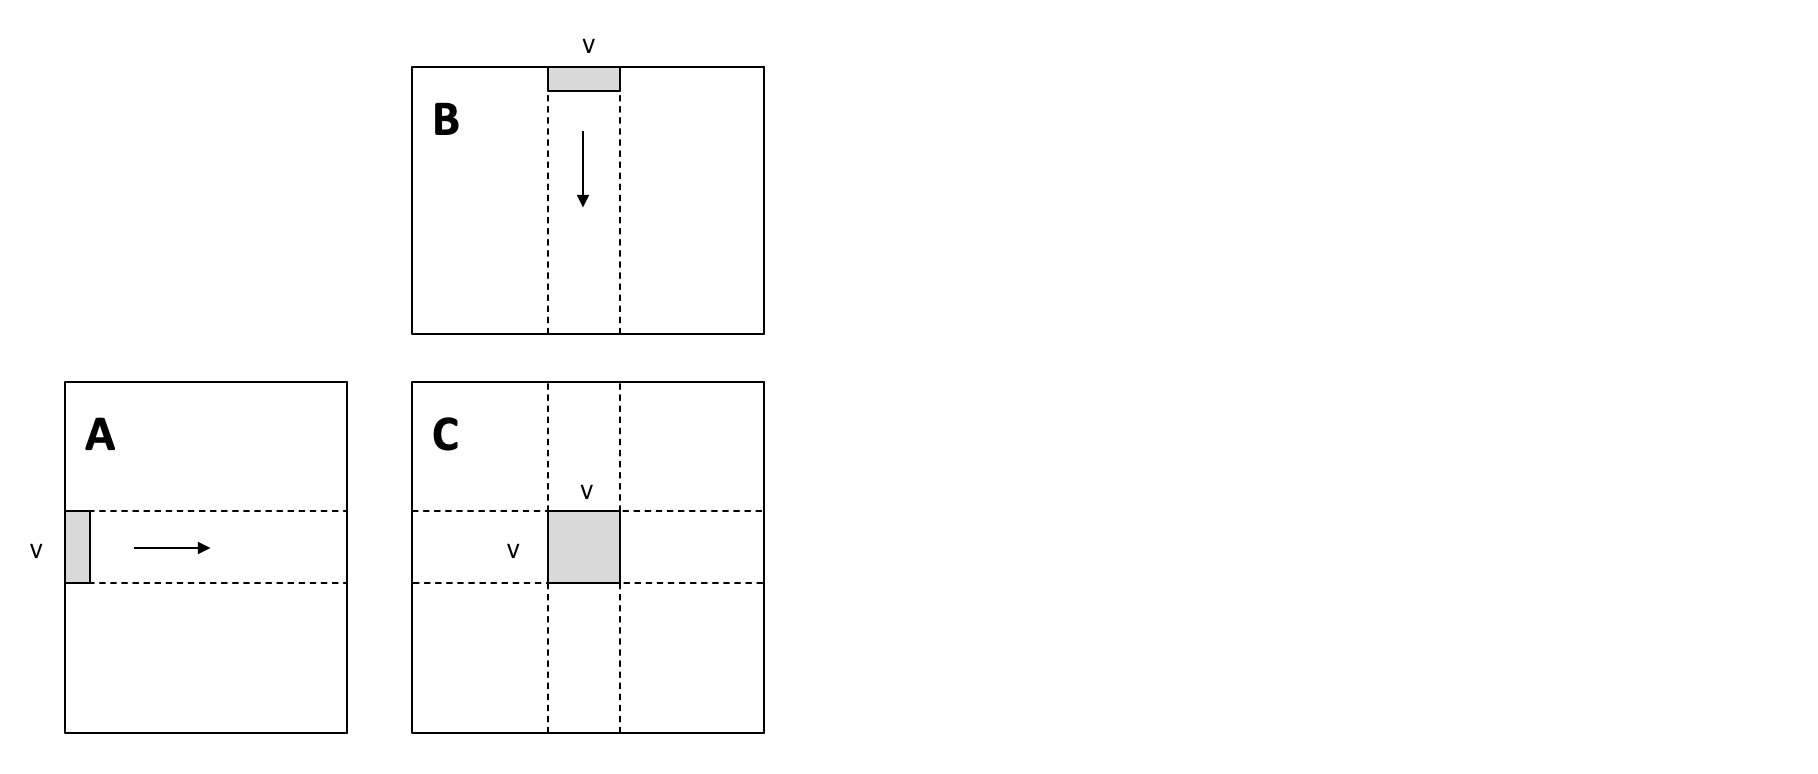

To increase overall memory reuse. We can tile the loops. In particular, we introduce local tiles such that we only need to load stripe of data from A and B once, then use them to perform a `V * V` matrix multiplication result.

This local tiling helps to reduce the memory pressure, as each element in the stripe is reused `V` times.

In [16]:
def blocking(sch, 
             tile_local_y, 
             tile_local_x, 
             tile_block_y, 
             tile_block_x,
             tile_k):
    block_C = sch.get_block("C")
    C_local = sch.cache_write(block_C, 0, "local")

    i, j, k = sch.get_loops(block=block_C)

    i0, i1, i2 = sch.split(loop=i, factors=[None, tile_block_y, tile_local_y])
    j0, j1, j2 = sch.split(loop=j, factors=[None, tile_block_x, tile_local_x])
    k0, k1 = sch.split(loop=k, factors=[None, tile_k])
    sch.unroll(k1)
    sch.reorder(i0, j0, i1, j1, k0, k1, i2, j2)
    sch.reverse_compute_at(C_local, j1)

    sch.bind(i0, "blockIdx.y")
    sch.bind(j0, "blockIdx.x")

    sch.bind(i1, "threadIdx.y")
    sch.bind(j1, "threadIdx.x")
    sch.decompose_reduction(block_C, k0)

    return sch

sch = tvm.tir.Schedule(MyModuleMatmul)
sch = blocking(sch, 8, 8, 8, 8, 4)
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(1024, 1024), "float32"], B: T.Buffer[(1024, 1024), "float32"], C: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        C_local = T.alloc_buffer([1024, 1024], dtype="float32", scope="local")
        for i_0 in T.thread_binding(16, thread="blockIdx.y"):
            for j_0 in T.thread_binding(16, thread="blockIdx.x"):
                for i_1 in T.thread_binding(8, thread="threadIdx.y"):
                    for j_1 in T.thread_binding(8, thread="threadIdx.x"):
                        for i_2_init, j_2_init in T.grid(8, 8):
                            with T.block("C_init"):
                                vi = T.axis.spatial(1024, i_0 * 64 + i_1 * 8 + i_2_init)
                                vj = T.axis.spatial(1024, j_0 * 64 + j_1 * 8 + j_2_init)
                       

In [17]:
rt_mod = tvm.build(sch.mod, target="cuda")
dev = tvm.cuda(0)
A_np = np.random.uniform(size=(1024, 1024)).astype("float32")
B_np = np.random.uniform(size=(1024, 1024)).astype("float32")
A_nd = tvm.nd.array(A_np, dev)
B_nd = tvm.nd.array(B_np, dev)
C_nd = tvm.nd.array(np.zeros((1024, 1024), dtype="float32"), dev)

num_flop = 2 * 1024 * 1024 * 1024
evaluator = rt_mod.time_evaluator("main", dev, number=10)


print("GEMM-Blocking: %f GFLOPS" % (num_flop / evaluator(A_nd, B_nd, C_nd).mean / 1e9))

GEMM-Blocking: 2378.997450 GFLOPS


## Shared Memory Blocking



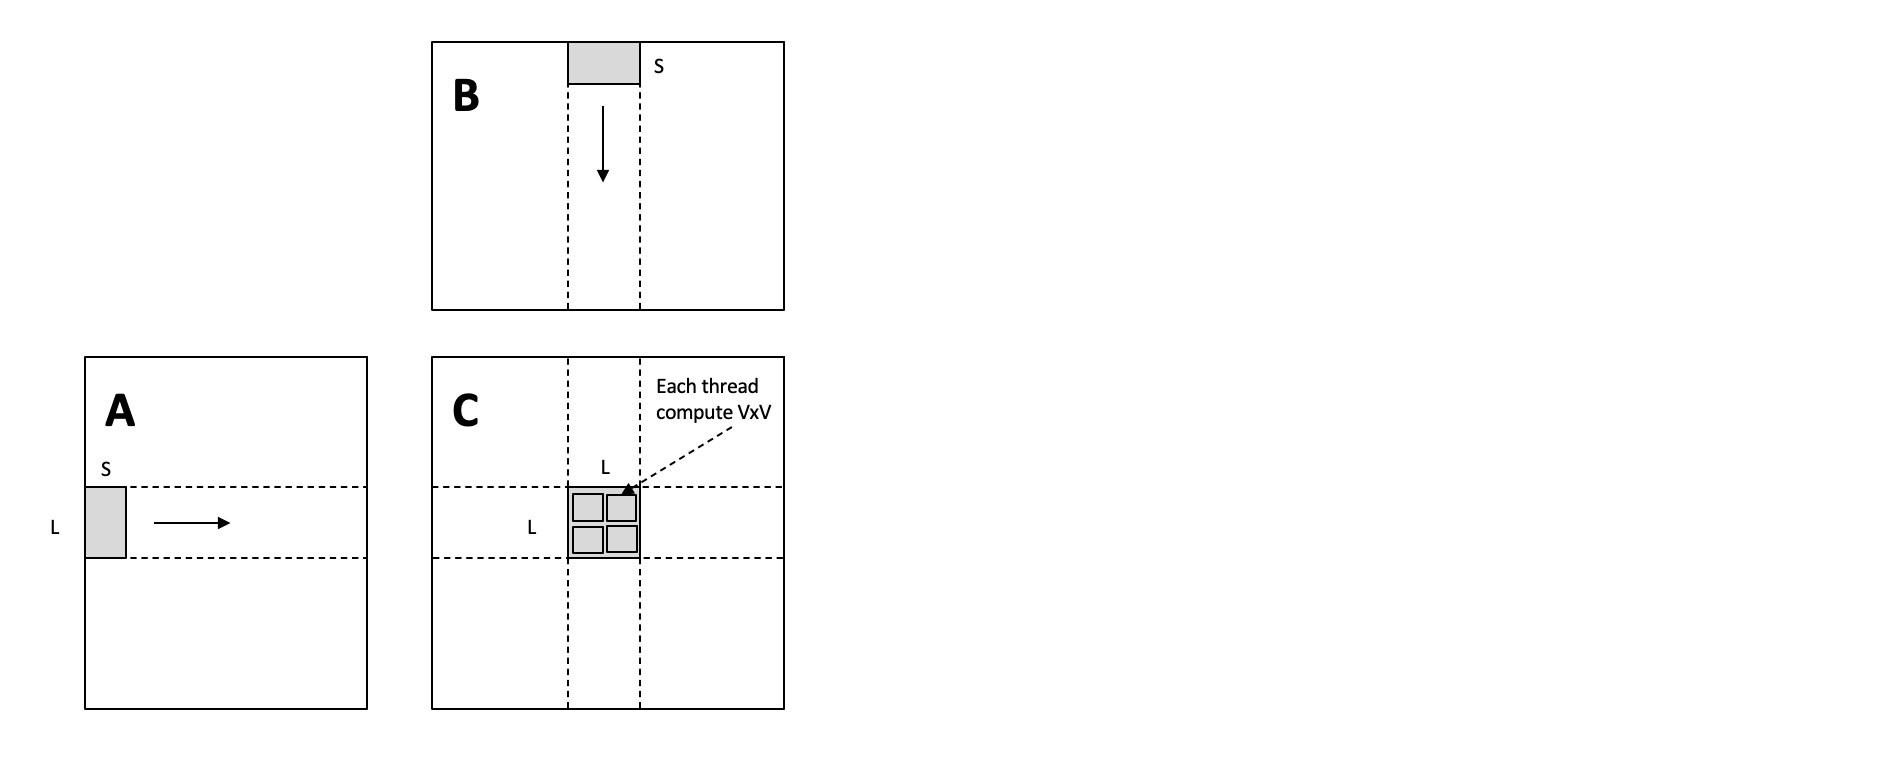

Our first attempt did not consider the neighboring threads which sit in the same GPU thread block, and we can load the data they commonly need into a piece of shared memory.

The following transformation does that.

In [19]:
def cache_read_and_coop_fetch(sch, block, nthread, read_idx, read_loc):
    read_cache = sch.cache_read(block=block, read_buffer_index=read_idx, storage_scope="shared")
    sch.compute_at(block=read_cache, loop=read_loc)
    # vectorized cooperative fetch
    inner0, inner1 = sch.get_loops(block=read_cache)[-2:]
    inner = sch.fuse(inner0, inner1)
    _, tx, vec = sch.split(loop=inner, factors=[None, nthread, 4])
    sch.vectorize(vec)
    sch.bind(tx, "threadIdx.x")


def blocking_with_shared(
    sch, 
    tile_local_y, 
    tile_local_x, 
    tile_block_y, 
    tile_block_x,
    tile_k):
    block_C = sch.get_block("C")
    C_local = sch.cache_write(block_C, 0, "local")

    i, j, k = sch.get_loops(block=block_C)

    i0, i1, i2 = sch.split(loop=i, factors=[None, tile_block_y, tile_local_y])
    j0, j1, j2 = sch.split(loop=j, factors=[None, tile_block_x, tile_local_x])
    k0, k1 = sch.split(loop=k, factors=[None, tile_k])

    sch.reorder(i0, j0, i1, j1, k0, k1, i2, j2)
    sch.reverse_compute_at(C_local, j1)

    sch.bind(i0, "blockIdx.y")
    sch.bind(j0, "blockIdx.x")

    tx = sch.fuse(i1, j1)
    sch.bind(tx, "threadIdx.x")
    nthread = tile_block_y * tile_block_x
    cache_read_and_coop_fetch(sch, block_C, nthread, 0, k0)
    cache_read_and_coop_fetch(sch, block_C, nthread, 1, k0)    
    sch.decompose_reduction(block_C, k0)

    return sch

sch = tvm.tir.Schedule(MyModuleMatmul)
sch = blocking_with_shared(sch, 8, 8, 8, 8, 8)
sch.mod.show()


@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(1024, 1024), "float32"], B: T.Buffer[(1024, 1024), "float32"], C: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        C_local = T.alloc_buffer([1024, 1024], dtype="float32", scope="local")
        A_shared = T.alloc_buffer([1024, 1024], dtype="float32", scope="shared")
        B_shared = T.alloc_buffer([1024, 1024], dtype="float32", scope="shared")
        for i_0 in T.thread_binding(16, thread="blockIdx.y"):
            for j_0 in T.thread_binding(16, thread="blockIdx.x"):
                for i_1_j_1_fused in T.thread_binding(64, thread="threadIdx.x"):
                    for i_2_init, j_2_init in T.grid(8, 8):
                        with T.block("C_init"):
                            vi = T.axis.spatial(1024, i_0 * 64 + i_1_j_1_fused // 8 * 8 + i_2_init)
          

In [20]:
rt_mod = tvm.build(sch.mod, target="cuda")
dev = tvm.cuda(0)
evaluator = rt_mod.time_evaluator("main", dev, number=10)

print("GEMM-Blocking: %f GFLOPS" % (num_flop / evaluator(A_nd, B_nd, C_nd).mean / 1e9))

GEMM-Blocking: 5672.038389 GFLOPS


## Leveraging Automatic Program Optimization

So far, we have been manually writing transformations to optimize the TensorIR program on GPU. We can leverage the automatic program optimization framework to tune the same program. The following code does that, we only set a small number here, and it can take a few min to finish. 

In [ ]:
from tvm import meta_schedule as ms

sch_tuned = ms.tune_tir(
    mod=MyModuleMatmul,
    target="nvidia/tesla-p100",
    config=ms.TuneConfig(
      max_trials_global=64,
      num_trials_per_iter=64,
    ),
    work_dir="./tune_tmp",
    task_name="main"
)

2022-08-06 13:02:40.921 INFO Logging directory: ./tune_tmp/logs
2022-08-06 13:02:40.928 INFO Logging directory: ./tune_tmp/logs
2022-08-06 13:02:40.930 INFO Working directory: ./tune_tmp
2022-08-06 13:02:40.933 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-08-06 13:02:40.935 INFO LocalBuilder: max_workers = 1
2022-08-06 13:02:41.536 INFO LocalRunner: max_workers = 1
2022-08-06 13:02:42.113 INFO Initializing Task #0: "main"
2022-08-06 13:02:42.130 INFO 
 ID | Name |       FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
---------------------------------------------------------------------------------------------------------------
  0 | main | 2147483648 |      1 |            N/A |          N/A |                   N/A |      0 |            
---------------------------------------------------------------------------------------------------------------
To

In [ ]:
sch_tuned.mod.show()

In [ ]:
rt_mod = tvm.build(sch_tuned.mod, target="nvidia/tesla-p100")
dev = tvm.cuda(0)
evaluator = rt_mod.time_evaluator("main", dev, number=10)

print("MetaSchedule: %f GFLOPS" % (num_flop / evaluator(A_nd, B_nd, C_nd).mean / 1e9))

## Summary

This chapter studies another axis of MLC -- how we can transform our program for hardware acceleration. The MLC process helps us to bridge the input models toward different GPU programming models and environments. We will visit more hardware specialization topics in the incoming chapter as well.

- A typical GPU contains two-level hierarchy. Each thread is indexed by(in cuda terminology) `threadIdx.x` and `blockIdx.x`(there can be multiple dimension indices as well, but they can be fused to one.
- Shared memory helps cache data commonly used across the threads within the same block.
- Encourage memory reuse during GPU optimization.
